## ana_proj_pres
read data of projected pressure and check that it seems OK

In [6]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from glob import glob
from pathlib import Path
import os, time

import numpy as np

import xarray as xr
#from xorca.lib import load_xorca_dataset
#from xgcm import Grid

#from itidenatl.nemodez import Vmodes
#import itidenatl.eos as eos
#import itidenatl.vars as var
#import itidenatl.gridop as gop
from itidenatl.tools import files as uf, dataio as io

In [3]:
from dask.distributed import Client, LocalCluster, wait
cluster = LocalCluster(n_workers=8, local_directory="/tmp") #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:38841 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [30]:
### define paths
scratch = Path(os.getenv("SCRATCHDIR"))
workdir = Path("/work/CT1/ige2071/nlahaye")
worksha = (workdir/"../SHARED").resolve()

vmod_path = workdir/"eNATL60_global-mean_vmodes.zarr"
#ssh_path = Path("/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h") # zarr
grid_path = scratch/"mesh_mask_eNATL60_3.6.nc"
modamp_dir = worksha/"modal_proj/modamp_pres"
modamp_nam = "modamp_pres_global_{}.zarr"

i_day = 235
i_mod = 0

In [31]:
ladate = uf.get_date_from_iday(i_day)

ds = xr.open_zarr(modamp_dir/modamp_nam.format(ladate)).sel(mode=[i_mod])
chks = {k[0]:v[0] for k,v in ds.chunks.items() if k in ["x_c", "y_c"]}
dm = xr.open_zarr(vmod_path).chunk({k+"_c":chks[k] for k in ["x","y"]})
mask = (~xr.ufuncs.isnan(dm.norm.isel(mode=0, missing_dims="ignore")).reset_coords(drop=True)).persist()
ds = ds.assign_coords(mask=mask)

for c in ["llon_cc", "llat_cc"]:
    if c in ds.coords:
        ds[c] = io.open_one_coord(grid_path, chunks=chks, varname=c)[c]
    else:
        ds = ds.assign_coords({c:io.open_one_coord(grid_path, chunks=chks, varname=c)[c]})
ds


/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


<xarray.Dataset>
Dimensions:  (mode: 1, t: 24, y_c: 4729, x_c: 8354)
Coordinates:
  * mode     (mode) int64 0
  * t        (t) datetime64[ns] 2010-02-20T00:30:00 ... 2010-02-20T23:30:00
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 ... 4723 4724 4725 4726 4727 4728 4729
    mask     (y_c, x_c) bool dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llon_cc  (y_c, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llat_cc  (y_c, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
Data variables:
    pres     (t, y_c, x_c, mode) float32 dask.array<chunksize=(24, 400, 8354, 1), meta=np.ndarray>
Attributes:
    creator:            N. Lahaye (noe.lahaye@inria.fr)
    date_generated:     2022-04-26 (Tue at 02 h)
    day_of_simulation:  20100220
    description:        pressure modal amplitude, resulting from the projecti...
    from_files:         ['/work/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-...
    generating_script:  proj_pres_custdist.visu.py
    iday:               235
    simulation:         eNATL60 (with tides)

In [32]:
it = 12
slih = slice(0,None,10)
sds = ds.isel(x_c=slih, y_c=slih)
pmod_moy = sds.pres.mean("t").persist()
toplot = (sds.pres.isel(t=it)-pmod_moy).persist()

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 579 ms, sys: 55.5 ms, total: 634 ms
Wall time: 1.45 s


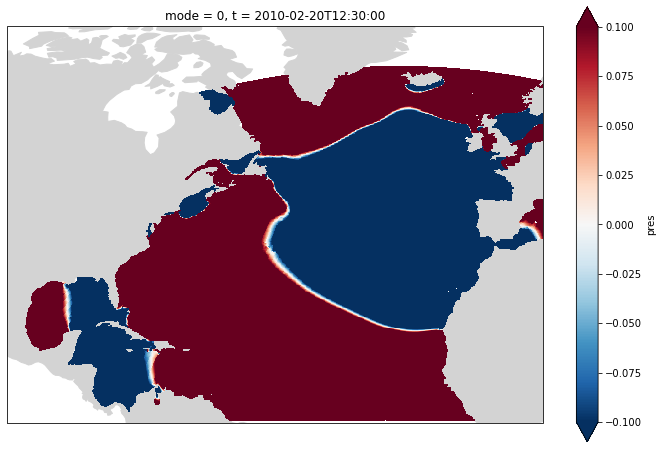

In [33]:
%%time
#map_proj = ccrs.LambertConformal(central_longitude=-28, central_latitude=39)
map_proj = ccrs.Robinson(central_longitude=-28)
norm = mpl.colors.Normalize(vmin=-.1, vmax=.1)
cmap = "RdBu_r"

fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=map_proj)
#ax.coastlines()
#gl = ax.gridlines()
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.set_extent([-100, 2, 6, 68])
p = toplot.squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon_cc", y="llat_cc", 
                                    norm=norm, cmap=cmap)
#ax.set_aspect('equal', 'box-forced') # this raises an error


In [34]:
### harmonic extraction
time = (ds.t - ds.t[0]).dt
time = time.days*24. + time.seconds/3600. 

ds = ds.assign_coords(time=time.persist())
ds.time.values

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.])

In [35]:
### define a window function

def planck_taper_ext(t, T=1., eps=.1, t0=0., normalized=True):
    """ planck taper window with transient centered at window length 
    quick and dirty implementation. Window is  centered
    planck taper with standard definition: transient centered at -T(.5-eps), T*(.5-eps). 
    extending time to T/(1-eps) make the interval between transient center equals T.
    return normalized window such that sum is 1 """
    #print("bornes, T, eps, t0:", t.min(), t.max(), T, eps, t0)
    if eps>=.5:
        raise ValueError("need eps<.5. Passed value is {:.2f}".format(eps))
    t = (t-t0)/T*(1.-eps) # use coordinate mapping: stretching 
    t1, t4 = -.5, .5
    win = np.where((t>t1) * (t<t4), 1., 0.)
    if eps > 0.:
        t2 = (eps-.5)
        t3 = (.5-eps)
        z_t = np.where(t<0., (t2-t1)/(t-t1) + (t2-t1)/(t-t2), (t3-t4)/(t-t3) + (t3-t4)/(t-t4))
        win = np.where((t<t2) + (t>t3), win/(np.exp(z_t)+1.), win)

    if normalized and win.max()>0.:
        win /= win.sum()
        
    return win


In [36]:
### Define periods and stuff
dt = float(ds.time.diff("t").mean())
f = 1./12.22
omega = 2*np.pi*f
eps_win = .4# relative length (in periods) of transient for time window
n_per = 1 # number of targeted periods / window
n_win = int(round( ((n_per+eps_win))/f/dt))
print("n_win :", n_win)

### harmonic extraction
# create rolling object and construt: window index is a new dim, "t_win"
def get_harmo(data, mask=None):
    if mask is None and mask is not False and "mask" in data.coords:
        mask = data.mask
    else:
        mask = None
    da_in = data.chunk({"t":-1})
    da_rol = da_in * xr.ufuncs.exp(-1.j*omega*da_in.time)
    da_rol = da_rol.rolling(t=n_win, center=True).construct("t_win")
    da_rol = da_rol.isel(t=slice(n_win//2,None,n_win))
    win = xr.DataArray(data=planck_taper_ext(da_in.time[:n_win], 
                                         T=n_per/f, eps=eps_win, 
                                         t0=da_in.time[:n_win].mean()), 
                   dims=("t_win"))
    res = (da_rol*win).sum("t_win")
    if mask is not None:
        res = res.where(mask)
    return res.astype("complex64")


n_win : 17


In [37]:
da_harmo = get_harmo(ds.pres).squeeze().persist()
da_harmo

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/xarray/core/dataarray.py:3061: FutureWarning: xarray.ufuncs is deprecated. Instead, use numpy ufuncs directly.
  da = self.__array_wrap__(f(self.variable.data, *args, **kwargs))


<xarray.DataArray (y_c: 4729, x_c: 8354)>
dask.array<getitem, shape=(4729, 8354), dtype=complex64, chunksize=(400, 8354), chunktype=numpy.ndarray>
Coordinates:
    mode     int64 0
    t        datetime64[ns] 2010-02-20T08:30:00
  * x_c      (x_c) int64 1 2 3 4 5 6 7 8 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c      (y_c) int64 1 2 3 4 5 6 7 8 ... 4723 4724 4725 4726 4727 4728 4729
    mask     (y_c, x_c) bool dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llon_cc  (y_c, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llat_cc  (y_c, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    time     float64 dask.array<chunksize=(), meta=np.ndarray>

In [38]:
### routine for preparing plots
plot_kwgs = {"figsize":(12,8),
             "central_lon":-50, "extent":[-97, 0, 6, 58],
                }       

def prep_one_plot(**kwargs):
    kwgs = plot_kwgs.copy()
    kwgs.update(kwargs)
    map_proj = ccrs.Robinson(central_longitude=kwgs["central_lon"])

    fig = plt.figure(figsize=kwgs["figsize"])
    ax = plt.axes(projection=map_proj)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.set_extent(kwgs["extent"])
    return fig, ax
                     

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 399 ms, sys: 65.1 ms, total: 464 ms
Wall time: 1.83 s


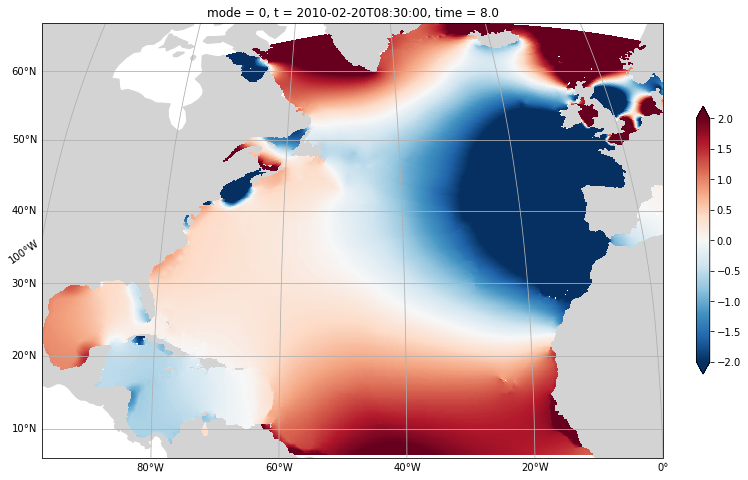

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/scratch/cnt0024/ige2071/nlahaye/conda/c

In [49]:
%%time
if i_mod>=1:
    amp = 0.05/i_mod
else:
    amp = 2.
norm = mpl.colors.Normalize(vmin=-amp, vmax=amp)
cmap = "RdBu_r"

fig, ax = prep_one_plot()
p = da_harmo.isel(x_c=slih, y_c=slih).real.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon_cc", y="llat_cc", 
                                    norm=norm, cmap=cmap, cbar_kwargs={"fraction":.02})

### SSH

In [15]:
dm = xr.open_zarr(vmod_path)
phi_surf = dm.phi.isel(mode=i_mod, z_c=0).persist()
phi_surf

<xarray.DataArray 'phi' (y_c: 4729, x_c: 8354)>
dask.array<getitem, shape=(4729, 8354), dtype=float32, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
    mode       int64 1
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
    z_c        int64 1

In [16]:
grav = 9.81/100
toplot = (phi_surf * get_harmo(ds.pres).squeeze() / grav).persist()
toplot

<xarray.DataArray (y_c: 4729, x_c: 8354)>
dask.array<truediv, shape=(4729, 8354), dtype=complex64, chunksize=(200, 200), chunktype=numpy.ndarray>
Coordinates:
    llat_cc    (y_c, x_c) float32 6.337 6.337 6.337 6.337 ... 54.43 54.42 54.42
    llon_cc    (y_c, x_c) float32 -97.88 -97.87 -97.85 ... 47.1 47.12 47.13
    mode       int64 1
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(1200, 1200), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
    z_c        int64 1
    t          datetime64[ns] 2009-07-31T08:30:00
    mask       (y_c, x_c) bool dask.array<chunksize=(400, 8354), meta=np.ndarray>
    time       float64 dask.array<chunksize=(), meta=np.ndarray>

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


CPU times: user 17.8 s, sys: 4.77 s, total: 22.6 s
Wall time: 21.1 s


Text(0.5, 1.0, '[cm]')

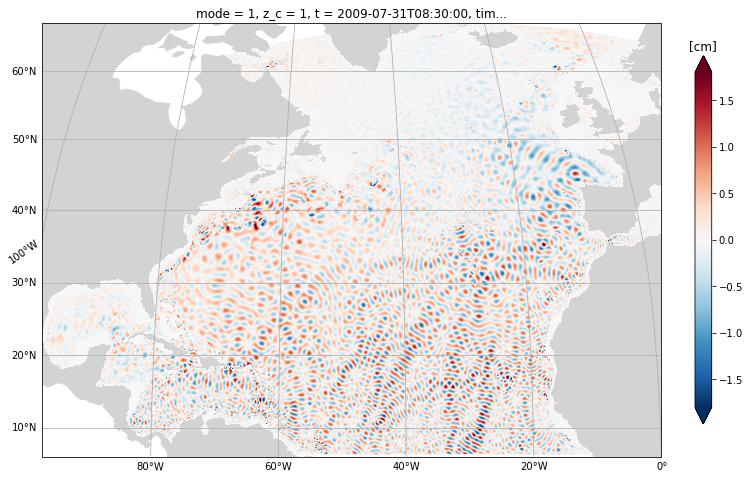

In [22]:
%%time
norm = mpl.colors.Normalize(vmin=-1.8, vmax=1.8)
cmap = "RdBu_r"

fig, ax = prep_one_plot()
p = toplot.real.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon_cc", y="llat_cc", 
                                    norm=norm, cmap=cmap, cbar_kwargs={"fraction":.025})
p.colorbar.ax.set_title(r"[cm]")

In [23]:
fig.savefig("figures/global_modal_ssh_harmo_{}.png".format(ladate), 
            dpi=200, bbox_inches="tight")

In [25]:
dir(p.colorbar)

['_ColorbarBase__scale',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_solids',
 '_boundaries',
 '_central_N',
 '_config_axis',
 '_edges',
 '_extend_lower',
 '_extend_upper',
 '_extended_N',
 '_find_range',
 '_get_extension_lengths',
 '_get_ticker_locator_formatter',
 '_inside',
 '_label',
 '_labelkw',
 '_locate',
 '_manual_tick_data_values',
 '_mesh',
 '_outline',
 '_process_values',
 '_proportional_y',
 '_reset_locator_formatter_scale',
 '_set_label',
 '_ticker',
 '_uniform_y',
 '_use_auto_colorbar_locator',
 '_values',
 '_y',
 'add_lines',
 'alpha',
 'ax',
 'boundaries',
 'cmap',
 'config_axis',
 'dividers',
 'draw_all',
 'drawedges',
 'extend',
 'extendfrac

In [24]:
p.colorbar

Type:        Colorbar
String form: <matplotlib.colorbar.Colorbar object at 0x2b8a69254350>
File:        /scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/matplotlib/colorbar.py
Docstring:  
This class connects a `ColorbarBase` to a `~.cm.ScalarMappable`
such as an `~.image.AxesImage` generated via `~.axes.Axes.imshow`.

.. note::
    This class is not intended to be instantiated directly; instead, use
    `.Figure.colorbar` or `.pyplot.colorbar` to create a colorbar.
